In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, log_loss, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [65]:
# Arrival delayed flights
db = pd.read_csv("AUS_WITH_WEATHER_2022_NUMERIC.csv")
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86866 entries, 0 to 86865
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0.1            86866 non-null  int64  
 1   Unnamed: 0              86866 non-null  int64  
 2   MONTH                   86866 non-null  int64  
 3   DAY_OF_MONTH            86866 non-null  int64  
 4   DAY_OF_WEEK             86866 non-null  int64  
 5   MKT_CARRIER_AIRLINE_ID  86866 non-null  int64  
 6   OP_CARRIER_FL_NUM       86866 non-null  int64  
 7   ORIGIN_AIRPORT_SEQ_ID   86866 non-null  int64  
 8   DEST_AIRPORT_SEQ_ID     86866 non-null  int64  
 9   CRS_DEP_TIME            86866 non-null  int64  
 10  DEP_TIME                86866 non-null  float64
 11  DEP_DELAY               86866 non-null  float64
 12  DEP_DEL15               86866 non-null  float64
 13  DEP_DELAY_GROUP         86866 non-null  float64
 14  CRS_ARR_TIME            86866 non-null

In [66]:
X = db.drop("DEP_DELAY", axis = 1)
y = db.loc[:, 'DEP_DELAY']

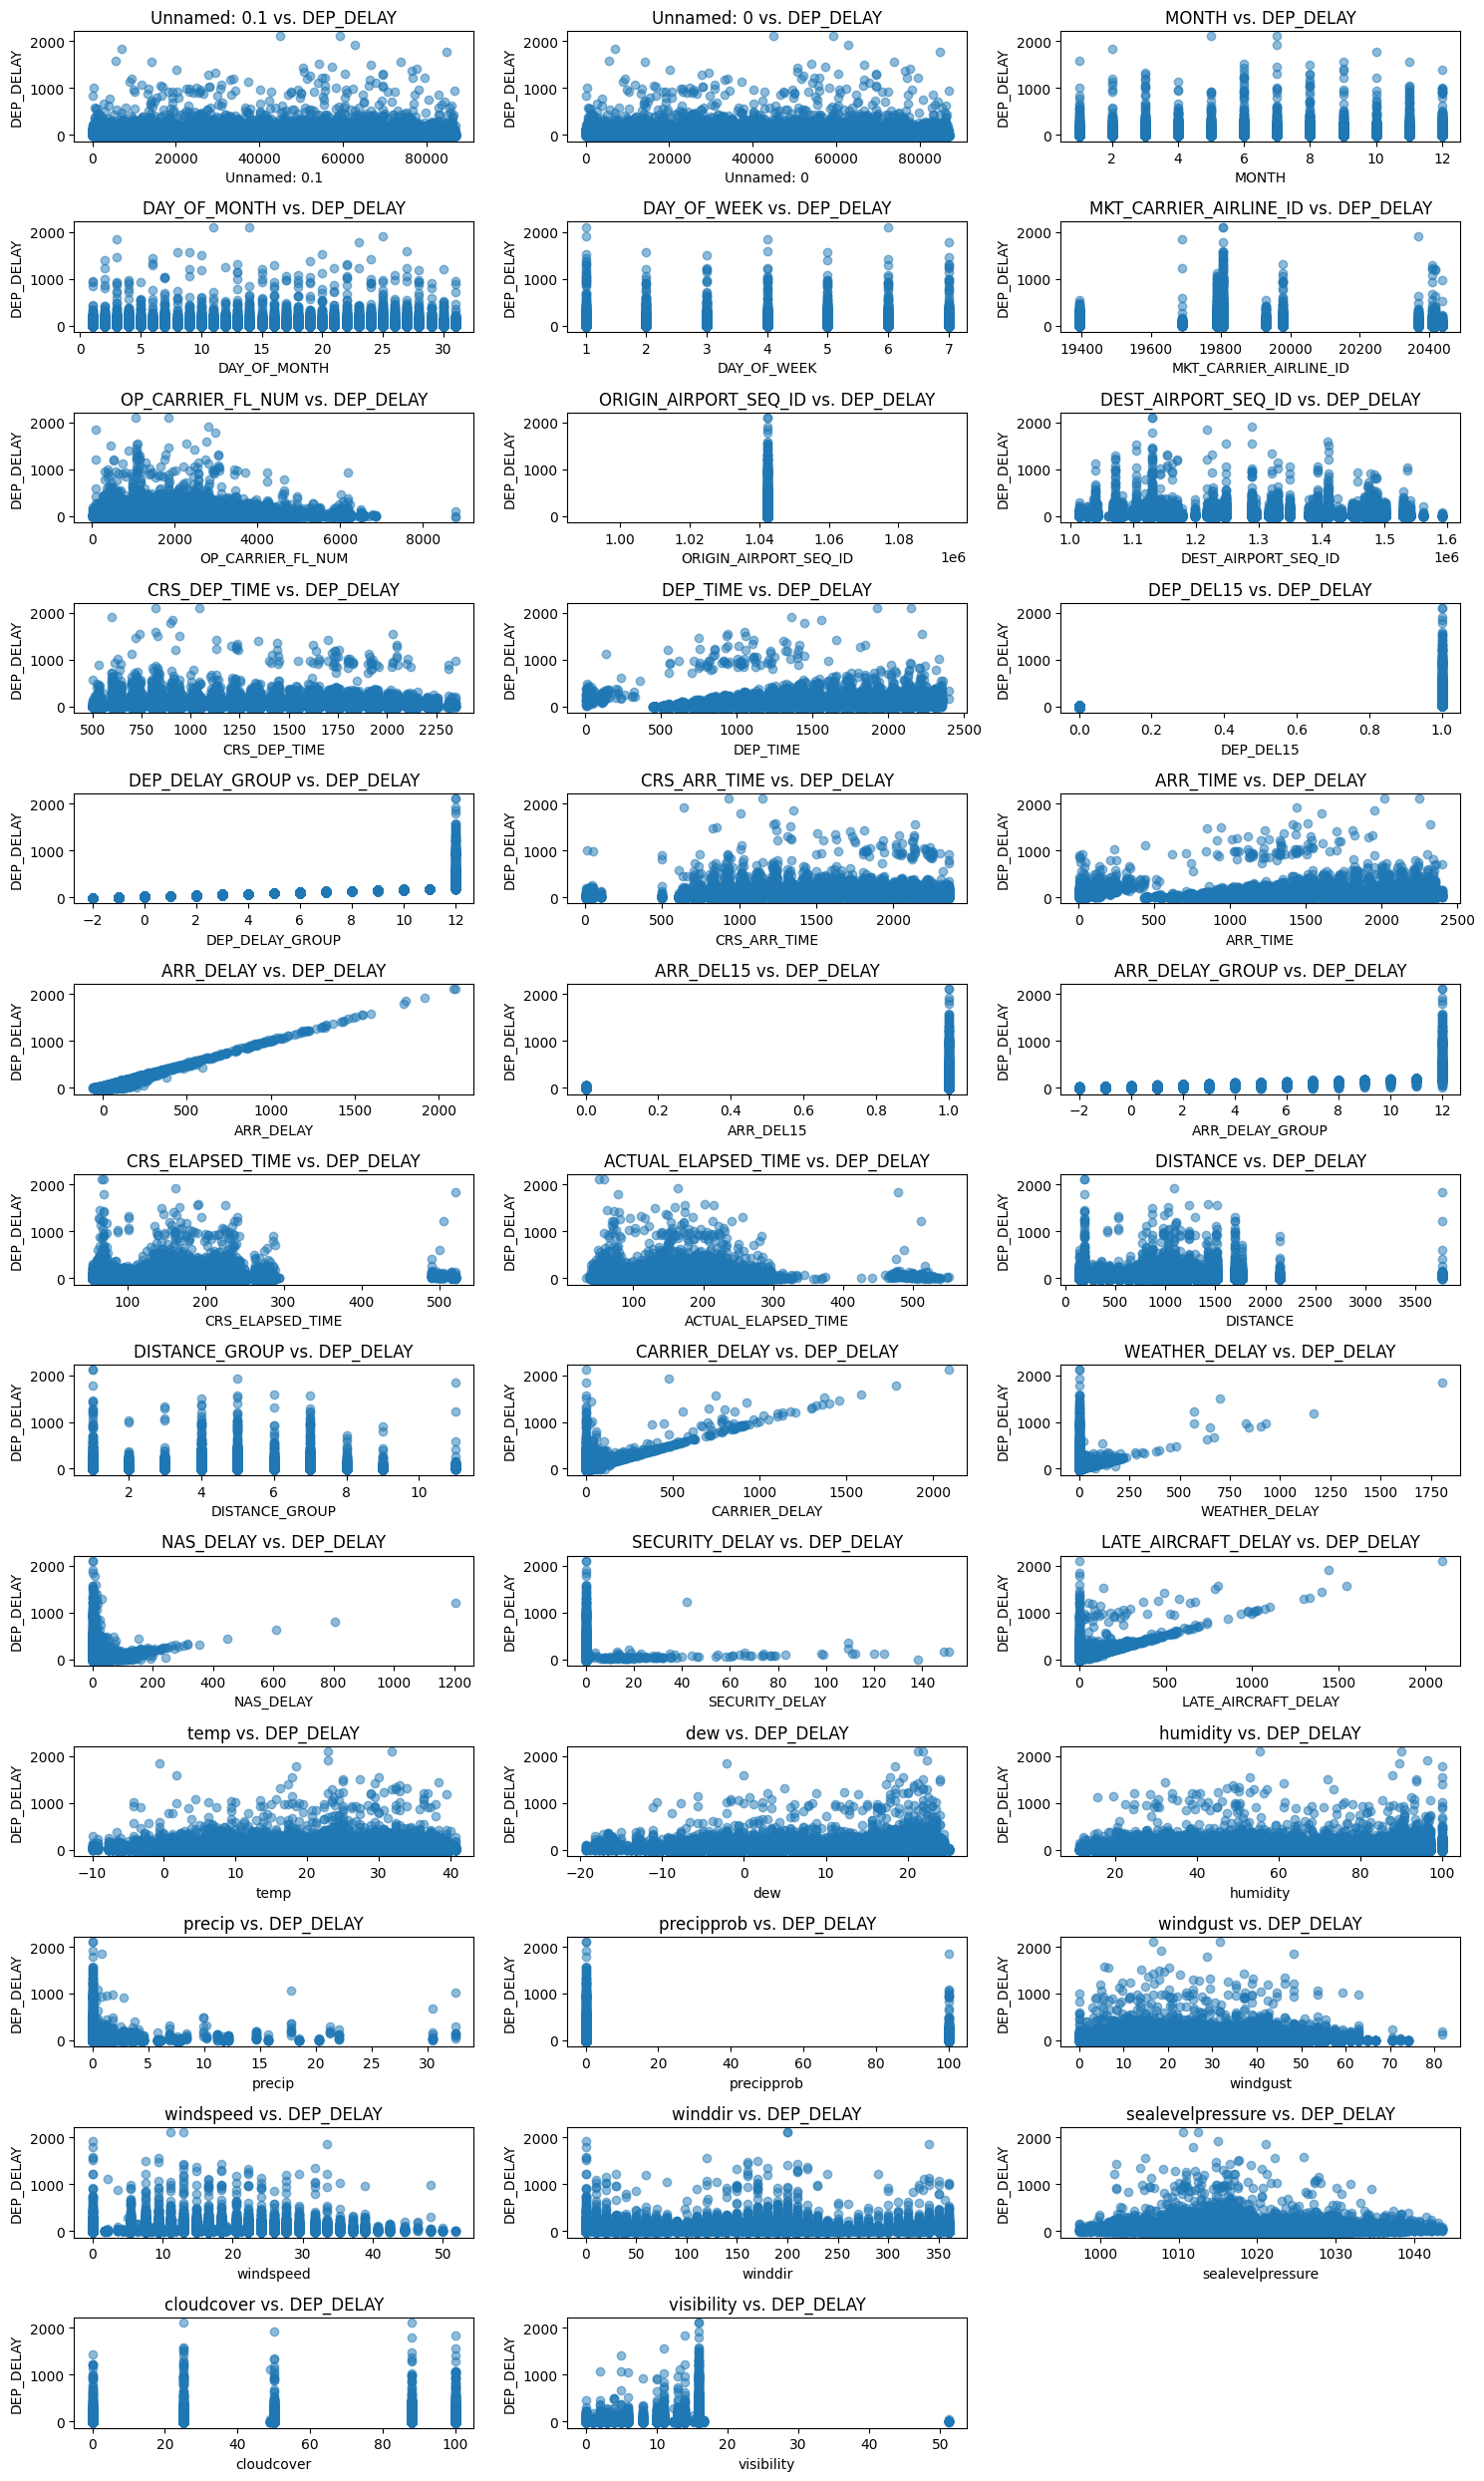

In [59]:
ind_vars = list(db.columns[:-1])
# Do not plot DEP_DELAY by against itself
ind_vars.remove('DEP_DELAY') 

# Compute number of rows and columns for grid of plots
n_cols = 3
n_rows = math.ceil(len(ind_vars) / n_cols)

# Create figure and axis objects for the grid of plots
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 25))

# Loop through each independent variable and create a plot
for i, var in enumerate(ind_vars):
    row_idx = i // n_cols
    col_idx = i % n_cols
    
    # Scatter plot of the independent variable vs. DEP_DELAY
    axs[row_idx, col_idx].scatter(db[var], db['DEP_DELAY'], alpha=0.5)
  
    axs[row_idx, col_idx].set_title(f'{var} vs. DEP_DELAY')
    axs[row_idx, col_idx].set_xlabel(var)
    axs[row_idx, col_idx].set_ylabel('DEP_DELAY')
    
# Hide any unused subplots
for i in range(len(ind_vars), n_rows*n_cols):
    row_idx = i // n_cols
    col_idx = i % n_cols
    axs[row_idx, col_idx].set_visible(False)
    
fig.tight_layout()
plt.show()

In [63]:
db = db.drop("ORIGIN_AIRPORT_SEQ_ID", axis = 1)
db = db.drop("CARRIER_DELAY", axis = 1)
db = db.drop("ARR_DELAY", axis = 1)
db = db.drop("DEP_DEL15", axis = 1)
db = db.drop("DEP_DELAY_GROUP", axis = 1)
db = db.drop(db.columns[0], axis = 1)
db = db.drop(db.columns[0], axis = 1)
#X = db.iloc[:, :-1].values
#y = db.iloc[:, -1].values
X = db.drop("DEP_DELAY", axis = 1)
y = db.loc[:, 'DEP_DELAY']
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86866 entries, 0 to 86865
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MONTH                   86866 non-null  int64  
 1   DAY_OF_MONTH            86866 non-null  int64  
 2   DAY_OF_WEEK             86866 non-null  int64  
 3   MKT_CARRIER_AIRLINE_ID  86866 non-null  int64  
 4   OP_CARRIER_FL_NUM       86866 non-null  int64  
 5   DEST_AIRPORT_SEQ_ID     86866 non-null  int64  
 6   CRS_DEP_TIME            86866 non-null  int64  
 7   DEP_TIME                86866 non-null  float64
 8   DEP_DELAY               86866 non-null  float64
 9   CRS_ARR_TIME            86866 non-null  int64  
 10  ARR_TIME                86866 non-null  float64
 11  ARR_DEL15               86866 non-null  float64
 12  ARR_DELAY_GROUP         86866 non-null  float64
 13  CRS_ELAPSED_TIME        86866 non-null  float64
 14  ACTUAL_ELAPSED_TIME     86866 non-null

In [93]:
# Scaling
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
db = pd.DataFrame(scaler.fit_transform(db), columns=db.columns)
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MONTH                   10000 non-null  float64
 1   DAY_OF_MONTH            10000 non-null  float64
 2   DAY_OF_WEEK             10000 non-null  float64
 3   MKT_CARRIER_AIRLINE_ID  10000 non-null  float64
 4   OP_CARRIER_FL_NUM       10000 non-null  float64
 5   DEST_AIRPORT_SEQ_ID     10000 non-null  float64
 6   CRS_DEP_TIME            10000 non-null  float64
 7   DEP_TIME                10000 non-null  float64
 8   DEP_DELAY               10000 non-null  float64
 9   CRS_ARR_TIME            10000 non-null  float64
 10  ARR_TIME                10000 non-null  float64
 11  CRS_ELAPSED_TIME        10000 non-null  float64
 12  ACTUAL_ELAPSED_TIME     10000 non-null  float64
 13  DISTANCE                10000 non-null  float64
 14  WEATHER_DELAY           10000 non-null 

In [50]:
# PCA test/train datasets
X_test = pd.read_csv("AUS_WITH_WEATHER_2022_NUMERIC_X_test_pca.csv")
X_train = pd.read_csv("AUS_WITH_WEATHER_2022_NUMERIC_X_train_pca.csv")
y_test = X_test.loc[:, 'DEP_DELAY']
y_train = X_train.loc[:, 'DEP_DELAY']
X_test = X_test.drop("DEP_DELAY", axis = 1)
X_test = X_test.drop("DEP_DEL15", axis = 1)
X_test = X_test.drop(X_test.columns[0], axis = 1)
X_train = X_train.drop("DEP_DELAY", axis = 1)
X_train = X_train.drop("DEP_DEL15", axis = 1)
X_train = X_train.drop(X_train.columns[0], axis = 1)
X_train.info()
X_test.info()
y_train.info()
y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65149 entries, 0 to 65148
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       65149 non-null  float64
 1   1       65149 non-null  float64
 2   2       65149 non-null  float64
 3   3       65149 non-null  float64
 4   4       65149 non-null  float64
 5   5       65149 non-null  float64
 6   6       65149 non-null  float64
 7   7       65149 non-null  float64
 8   8       65149 non-null  float64
 9   9       65149 non-null  float64
 10  10      65149 non-null  float64
 11  11      65149 non-null  float64
 12  12      65149 non-null  float64
 13  13      65149 non-null  float64
 14  14      65149 non-null  float64
 15  15      65149 non-null  float64
 16  16      65149 non-null  float64
 17  17      65149 non-null  float64
 18  18      65149 non-null  float64
 19  19      65149 non-null  float64
 20  20      65149 non-null  float64
 21  21      65149 non-null  float64
 22

In [67]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [68]:
def grid_search(model, params, model_name):
    # define your GridSearchCV object with the relevant parameters
    grid_search = GridSearchCV(model, params, cv=3, n_jobs=-1)

    # fit the grid search model with the train data and print the best parameters
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    # Calculate the mean squared error and R-squared values for the training and testing sets
    y_train_pred = grid_search.predict(X_train)
    y_test_pred = grid_search.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print the performance metrics
    print("Training set performance:")
    print(f"  Mean squared error: {train_mse:.2f}")
    print(f"  R-squared: {train_r2:.2f}")
    print("Testing set performance:")
    print(f"  Mean squared error: {test_mse:.2f}")
    print(f"  R-squared: {test_r2:.2f}")

    # Plot the predicted vs. actual departure delays for the training and testing sets
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].scatter(y_train, y_train_pred)
    axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
    axes[0].set_xlabel('Actual')
    axes[0].set_ylabel('Predicted')
    axes[0].set_title('Training Set')
    axes[1].scatter(y_test, y_test_pred)
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    axes[1].set_xlabel('Actual')
    axes[1].set_ylabel('Predicted')
    axes[1].set_title('Testing Set')
    plt.show()

    # Plot the results
    plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-50, xmax=750, lw=2, color='red')
    plt.xlim([-50, 750])
    plt.show()

    if (model_name == "MLP Regression"):
      coefficients = grid_search.best_estimator_.coefs_[0].mean(axis=1)
    else: 
      coefficients = grid_search.best_estimator_.coef_

    # Create bar chart
    plt.barh(db.columns[:-1], coefficients)
    plt.xlabel('Importance')
    plt.title(f"{model_name} Feature Importances")
    plt.show()

    return grid_search

Best parameters for Linear Regression: {'fit_intercept': True}
Training set performance:
  Mean squared error: 0.00
  R-squared: 1.00
Testing set performance:
  Mean squared error: 0.00
  R-squared: 1.00


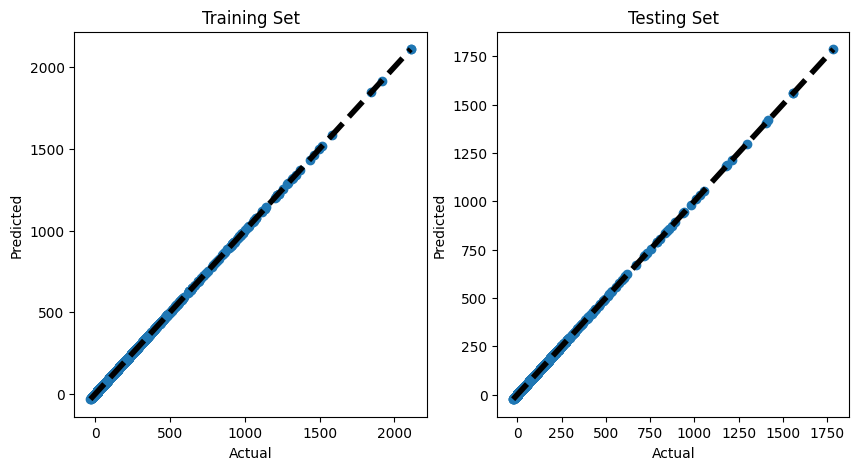

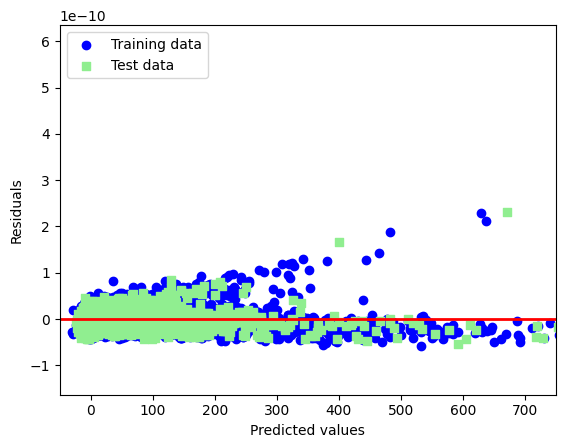

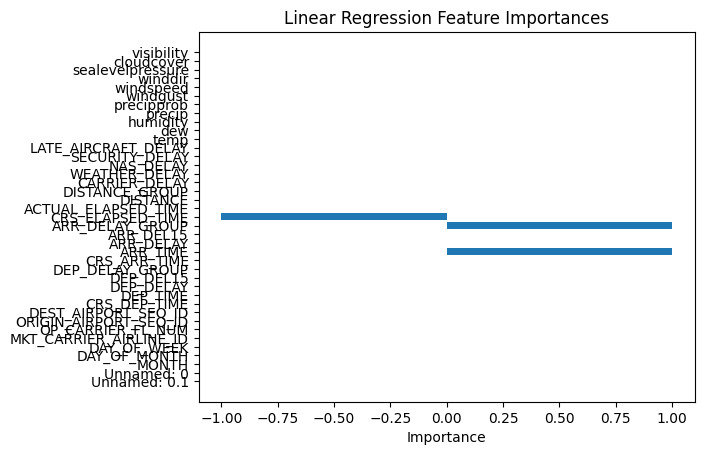

In [69]:
linReg_params = {
    'fit_intercept': [True, False]
}
linReg = LinearRegression()
linReg_gs = grid_search(linReg, linReg_params, "Linear Regression")

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
72 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py", line 1004, in fit
    _, this_coef, this_dual_gap, this_iter = self.path(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py", line 631, in enet_path
    model = cd_fast.enet_coordinat

Best parameters for Lasso Regression: {'alpha': 0.001, 'max_iter': 500, 'tol': 0.1}
Training set performance:
  Mean squared error: 885.36
  R-squared: 0.72
Testing set performance:
  Mean squared error: 834.59
  R-squared: 0.76


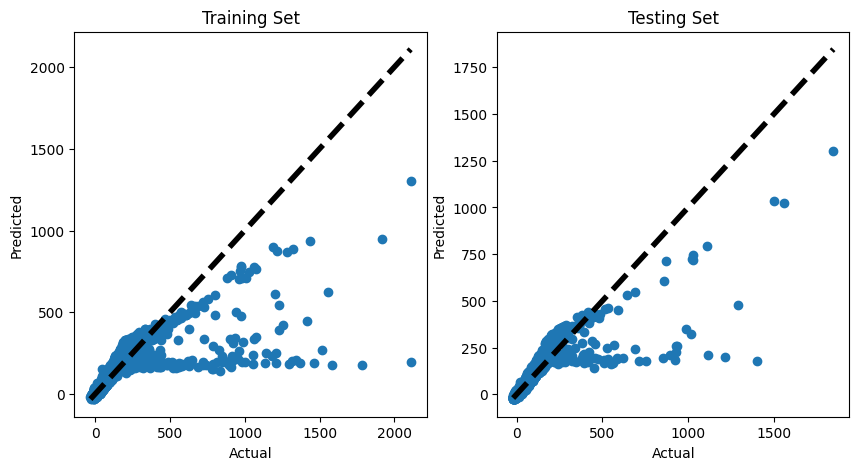

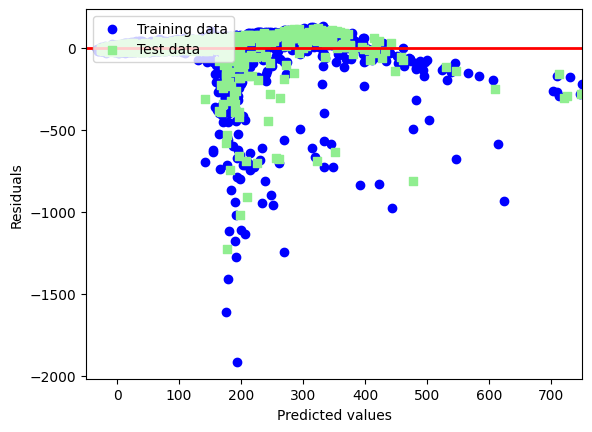

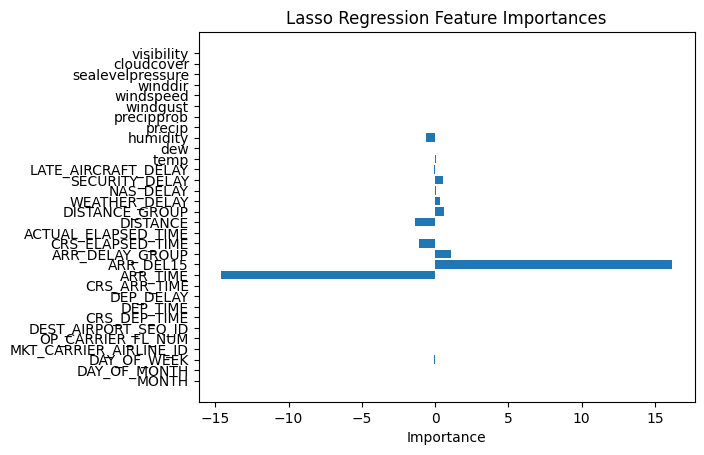

In [43]:
## Lasso Regression
lasso_params = {
              'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
              'max_iter': [None, 100, 500, 1000, 5000, 10000],
              'tol': [0.0001, 0.001, 0.01, 0.1]}
lasso = Lasso()
lasso_gs = grid_search(lasso, lasso_params, "Lasso Regression")

In [47]:
## Ridge Regression
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
              'max_iter': [None, 100, 500, 1000, 5000, 10000],
              'tol': [0.0001, 0.001, 0.01, 0.1]
              }
ridge = Ridge()
ridge_gs = grid_search(ridge, ridge_params, "Ridge Regression")

KeyboardInterrupt: ignored

Best parameters for MLP Regression: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,)}
Training set performance:
  Mean squared error: 77465.06
  R-squared: -23.53
Testing set performance:
  Mean squared error: 76987.29
  R-squared: -20.71


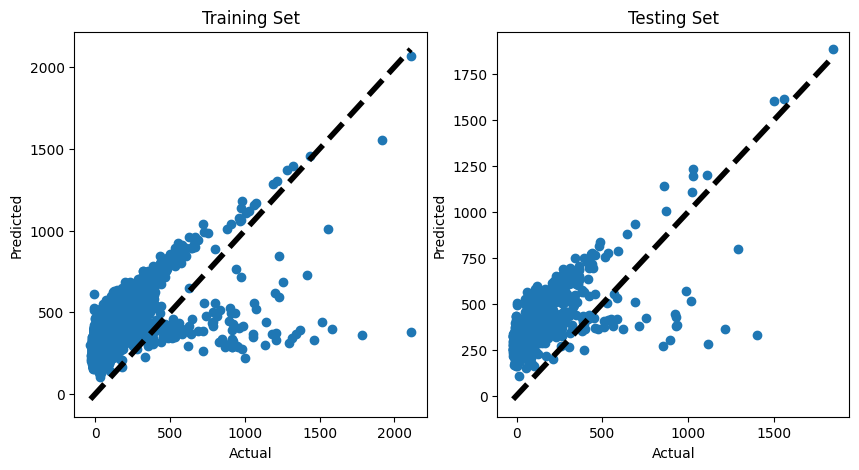

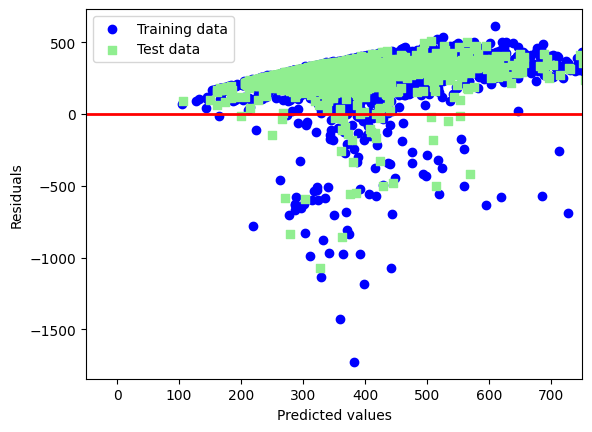

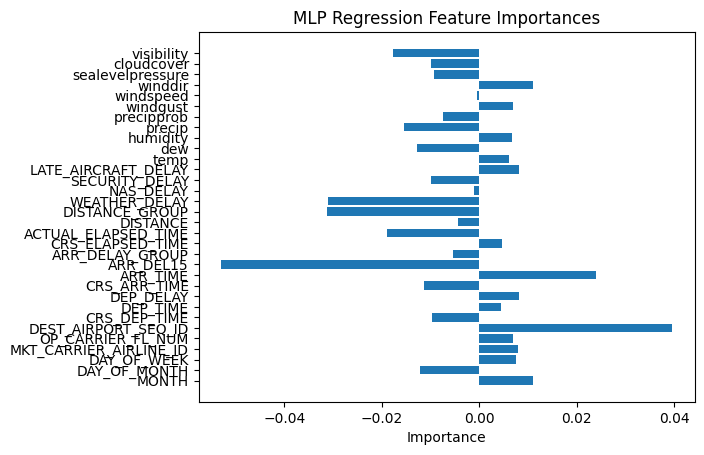

In [46]:
## MLP Regressor
mlp_params_shortlist = mlp_params = {
    'hidden_layer_sizes': [(50,), (50, 50)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.01, 0.001],
}
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
}
mlp = MLPRegressor()
mlp_gs = grid_search(mlp, mlp_params_shortlist, "MLP Regression")